# Experiment Notebook

In [1]:
# Run this cell as is:

import datetime
import json
import os 
import shutil
import sys
import uuid
import yaml

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

sys.path.append(os.path.join("..", "code"))
from cnn_dataset import CNNSeqDataset
from cnn_models import GAPTransArchitecture, GAPTransMaxArchitecture, \
ConvResizeGAPTransArchitecture, ImgSizeCNN
from utils import convert_datetime

pd.set_option("display.max_colwidth", 500)

DIR = os.getcwd()
DATA_DIR = os.path.join(os.path.dirname(DIR), "data")
EXPERIMENT_DIR = os.path.join(os.path.dirname(DIR), "experiments")
if not os.path.exists(EXPERIMENT_DIR):
    os.mkdir(EXPERIMENT_DIR)

## Experiment Parameters

#### Adjust these parameters for the desired experiment:

In [2]:
# Change the parameters here for the desired experiment settings:

PARAMETERS = dict(
    gages=[ '11266500'], #'11402000', '11189500', '11318500',, '11202710',], # '11208000','11185500'],
    y_col= "m3", # "m3_per_area_km", "m3_per_area_miles"
    n_days_precip=7,
    n_days_temp=7,
    n_days_et=8,
    swe_days_relative=[7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84],
    n_days_y=1,
    y_seq=False, 
    use_masks=True,
    shuffle_train=True,

    # Model architecture params:
    # dem_kernal=(5, 5), dem_strides=(1, 1),
    # et_kernal=(4, 4), et_strides=(1, 1),
    # temp_kernal=(2, 2), temp_strides=(1, 1),
    # precip_kernal=(2, 2), precip_strides=(1, 1),
    # swe_kernal=(5, 5), swe_strides=(1, 1),
    enc_embed_dim=8, enc_dense_dim=24, enc_num_heads=4,
    # dec_embed_dim=24, dec_dense_dim=48, dec_num_heads=4,
    hidden_dim=8, dropout=0.5, 
    pooling="flatten",
    
    # CNN parameters for resizing models:
    # cnn_activation="relu",
    # kernal=(2, 2), strides=(1, 1),

    # Model training params:
    epochs=3,
    learning_rate=0.0001,
    opt=keras.optimizers.Adam,
    loss="mean_squared_error",
    tf_board_update_freq=100,
)

In [3]:
# Run this cell as is:

PARAMETERS["n_swe"] = len(list(PARAMETERS["swe_days_relative"]))
PARAMETERS["n_et"] = PARAMETERS["n_days_et"] // 8

experiment = dict()
experiment["start_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
experiment_id = str(uuid.uuid4())
print(f"experiment['experiment_id'] = '{experiment_id}'")
experiment["id"] = experiment_id
TF_LOG_DIR = os.path.join(EXPERIMENT_DIR, experiment_id)
if not os.path.exists(TF_LOG_DIR):
    os.mkdir(TF_LOG_DIR)
    
FEATURES = ("dem", "temp", "precip", "swe", "et")
TRAIN_DIR = os.path.join(DATA_DIR, "training_data") 
Y_FP = os.path.join(DATA_DIR, "streamgage-full.csv")
dates = {
    "train": {
        "start": "2010_01_01", 
        "end": "2014_12_31", 
    },
    "val": {
        "start": "2015_01_01", 
        "end": "2015_12_31", 
    },
    "test": {
        "start": "2016_01_01", 
        "end": "2016_12_31", 
    },
}
DATE_PARAMS = dict()
for k, v in dates.items():
    DATE_PARAMS[k] = dict()
    for k2, v2 in v.items():
        DATE_PARAMS[k][k2] = convert_datetime(v2)

experiment['experiment_id'] = '17cb69f2-488e-4e00-9ce9-ed365cef71bf'


## Create dataset instance

In [5]:
# Run this cell as is:
cnn_data = CNNSeqDataset(
    precip_dirs=[TRAIN_DIR],
    temp_dirs=[TRAIN_DIR],
    et_dirs=[TRAIN_DIR],
    swe_dirs=[TRAIN_DIR],
    y_fp=Y_FP,
    y_col=PARAMETERS["y_col"],
    n_d_precip=PARAMETERS["n_days_precip"],
    n_d_temp=PARAMETERS["n_days_temp"],
    n_d_et=PARAMETERS["n_days_et"],
    swe_d_rel=PARAMETERS["swe_days_relative"],  
    n_d_y=PARAMETERS["n_days_y"],
    min_date=DATE_PARAMS["train"]["start"],
    max_date=DATE_PARAMS["test"]["end"],
    val_start=DATE_PARAMS["val"]["start"],
    test_start=DATE_PARAMS["test"]["start"],
    use_masks=PARAMETERS["use_masks"],
    random_seed=42,
    shuffle_train=PARAMETERS["shuffle_train"],  
    gages=PARAMETERS["gages"], 
)

print(f"Num training examples = {len(cnn_data.train_pairs)}")

Calculating pixel mean/std from 1 images


100%|██████████| 1/1 [00:00<00:00, 10.23it/s]

Num training examples = 1742


## Create the Model

In [6]:
# Run this cell to use the GAPTransArchitecture:

experiment["architecture"] = "GAPTransArchitecture"

def get_gt_model():
    # Create the model architecture:
    architecture = GAPTransArchitecture()
    model = architecture.get_model(
        dem_kernal=PARAMETERS["dem_kernal"], dem_strides=PARAMETERS["dem_strides"],
        et_kernal=PARAMETERS["et_kernal"], et_strides=PARAMETERS["et_strides"],
        temp_kernal=PARAMETERS["temp_kernal"], temp_strides=PARAMETERS["temp_strides"],
        precip_kernal=PARAMETERS["precip_kernal"], precip_strides=PARAMETERS["precip_strides"],
        swe_kernal=PARAMETERS["swe_kernal"], swe_strides=PARAMETERS["swe_strides"],
        n_days_precip=PARAMETERS["n_days_precip"],  n_days_temp=PARAMETERS["n_days_temp"],
        n_swe=PARAMETERS["n_swe"], n_et=PARAMETERS["n_et"],
        enc_embed_dim=PARAMETERS["enc_embed_dim"], enc_dense_dim=PARAMETERS["enc_dense_dim"],
        enc_num_heads=PARAMETERS["enc_num_heads"],
        dec_embed_dim=PARAMETERS["dec_embed_dim"], dec_dense_dim=PARAMETERS["dec_dense_dim"],
        dec_num_heads=PARAMETERS["dec_num_heads"],
        n_y=PARAMETERS["n_days_y"], hidden_dim=PARAMETERS["hidden_dim"], 
        dropout=PARAMETERS["dropout"], 
        pooling=PARAMETERS["pooling"],
    )
    return model

model = get_gt_model()
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__model.png")
keras.utils.plot_model(model, fp, show_shapes=True)

In [ ]:
# Run this cell to use the GAPTransMaxArchitecture:

experiment["architecture"] = "GAPTransMaxArchitecture"

def get_gtm_model():
    # Create the model architecture:
    architecture = GAPTransMaxArchitecture()
    model = architecture.get_model(
        kernal=PARAMETERS["kernal"], strides=PARAMETERS["strides"],
        n_days_precip=PARAMETERS["n_days_precip"],  n_days_temp=PARAMETERS["n_days_temp"],
        n_swe=PARAMETERS["n_swe"], n_et=PARAMETERS["n_et"],
        enc_embed_dim=PARAMETERS["enc_embed_dim"], enc_dense_dim=PARAMETERS["enc_dense_dim"],
        enc_num_heads=PARAMETERS["enc_num_heads"],
        dec_embed_dim=PARAMETERS["dec_embed_dim"], dec_dense_dim=PARAMETERS["dec_dense_dim"],
        dec_num_heads=PARAMETERS["dec_num_heads"],
        n_y=PARAMETERS["n_days_y"], hidden_dim=PARAMETERS["hidden_dim"], 
        dropout=PARAMETERS["dropout"],
        cnn_activation=PARAMETERS["cnn_activation"]
    )
    return model

model = get_gtm_model()
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__model.png")
keras.utils.plot_model(model, fp, show_shapes=True)

In [ ]:
# Run this cell to use the ConvResizeGAPTransArchitecture:

# Additional parameters:
PARAMETERS["et_ksize"] = PARAMETERS.get("et_ksize", (9, 9))
PARAMETERS["swe_ksize"] = PARAMETERS.get("swe_ksize", (35, 35))
PARAMETERS["dem_ksize"] = PARAMETERS.get("dem_ksize", (138, 138))
PARAMETERS["one_day_pred"] = not PARAMETERS["y_seq"]
if PARAMETERS["one_day_pred"]:
    PARAMETERS["final_dense_dim"] = PARAMETERS.get("final_dense_dim", None)
else:
    PARAMETERS["final_dense_dim"] = PARAMETERS["n_days_y"]
                        
experiment["architecture"] = "ConvResizeGAPTransArchitecture"

def get_conv_resize_model():
    # Create the model architecture:
    architecture = ConvResizeGAPTransArchitecture()
    
    model = architecture.get_model(
        et_ksize=PARAMETERS["et_ksize"],
        swe_ksize=PARAMETERS["swe_ksize"],
        dem_ksize=PARAMETERS["dem_ksize"],
        kernal=PARAMETERS["kernal"], strides=PARAMETERS["strides"],
        n_days_precip=PARAMETERS["n_days_precip"], n_days_temp=PARAMETERS["n_days_temp"],
        n_swe=PARAMETERS["n_swe"], n_et=PARAMETERS["n_et"],
        enc_embed_dim=PARAMETERS["enc_embed_dim"], enc_dense_dim=PARAMETERS["enc_dense_dim"],
        enc_num_heads=PARAMETERS["enc_num_heads"],
        dec_embed_dim=PARAMETERS["dec_embed_dim"], dec_dense_dim=PARAMETERS["dec_dense_dim"],
        dec_num_heads=PARAMETERS["dec_num_heads"],
        final_dense_dim=PARAMETERS["final_dense_dim"],
        one_day_pred=PARAMETERS["one_day_pred"],
        hidden_dim=PARAMETERS["hidden_dim"], 
        dropout=PARAMETERS["dropout"], 
        cnn_activation=PARAMETERS["cnn_activation"],
        pooling=PARAMETERS["pooling"],
    )
    return model

model = get_conv_resize_model()
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__model.png")
keras.utils.plot_model(model, fp, show_shapes=True)

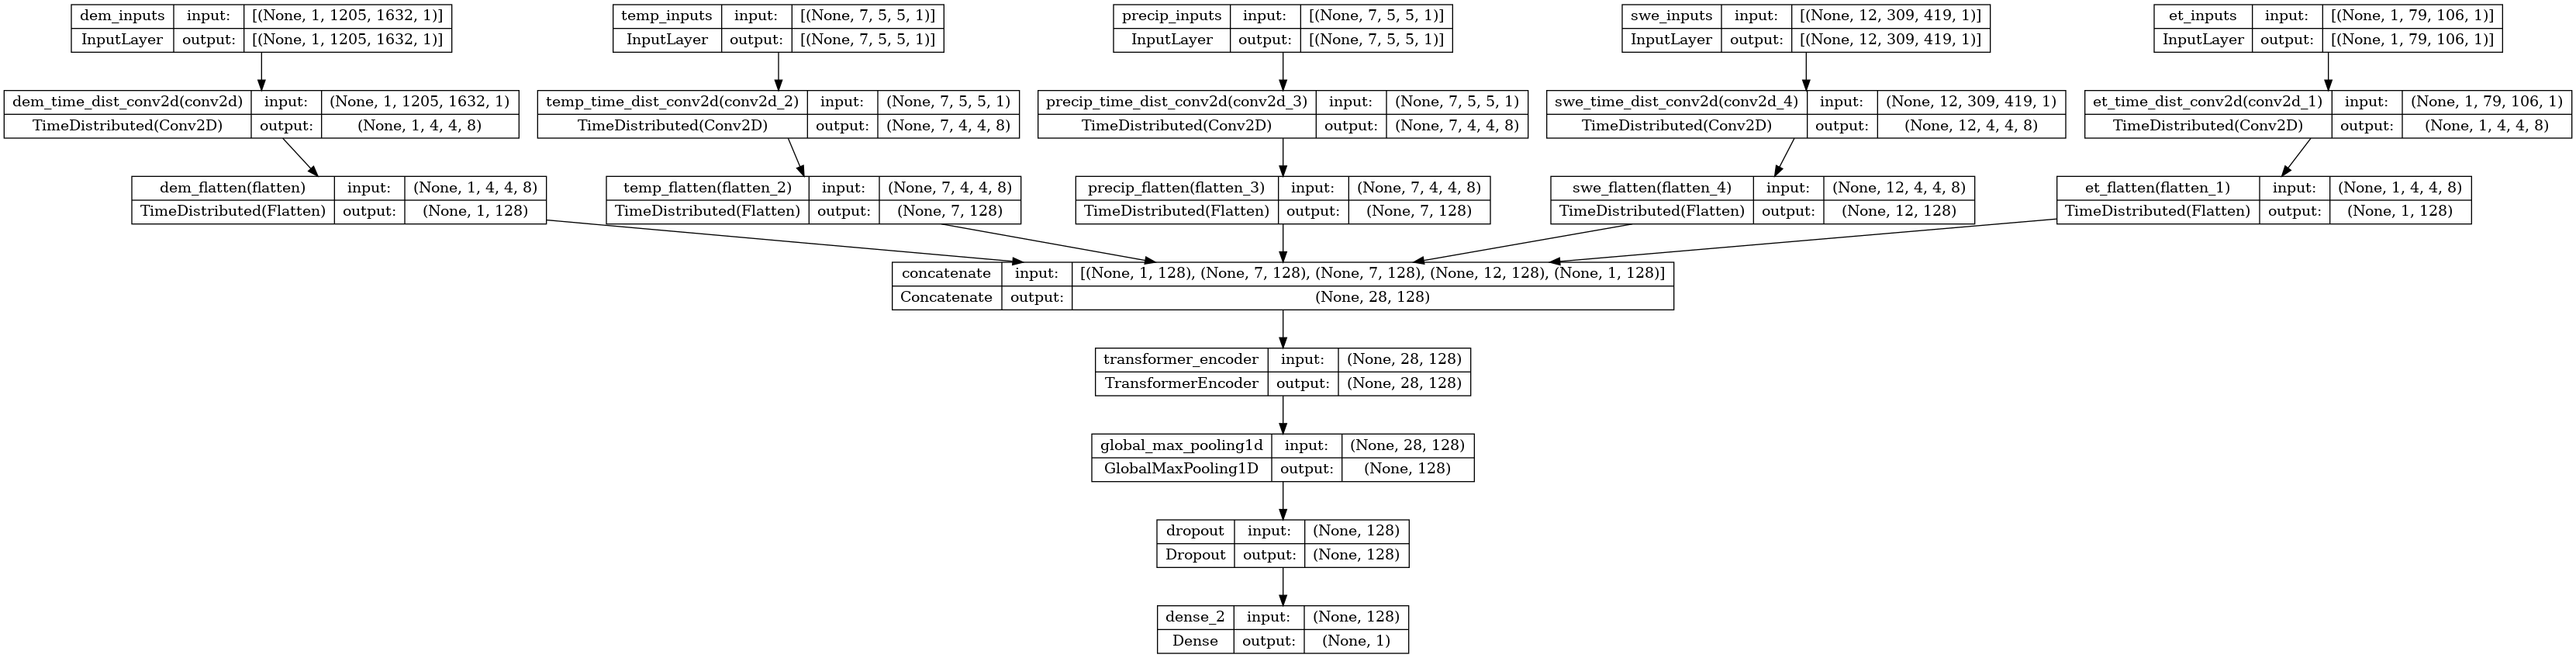

In [6]:
# Run this cell to use the ImgSizeCNN:

assert len(PARAMETERS["gages"]) == 1
experiment["architecture"] = "ImgSizeCNN"

def get_imgsize_cnn_model():
    # Create the model architecture:
    architecture = ImgSizeCNNArchitecture()
    
    model = architecture.get_model(
        PARAMETERS["gages"][0],
        n_days_precip=PARAMETERS["n_days_precip"], n_days_temp=PARAMETERS["n_days_temp"],
        n_swe=PARAMETERS["n_swe"], n_et=PARAMETERS["n_et"],
        enc_dense_dim=PARAMETERS["enc_dense_dim"], enc_num_heads=PARAMETERS["enc_num_heads"],
        n_y=PARAMETERS["n_days_y"], hidden_dim=PARAMETERS["hidden_dim"], 
        dropout=PARAMETERS["dropout"], 
        pooling=PARAMETERS["pooling"],
    )
    return model

model = get_imgsize_cnn_model()
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__imgsize_model.png")
keras.utils.plot_model(model, fp, show_shapes=True)

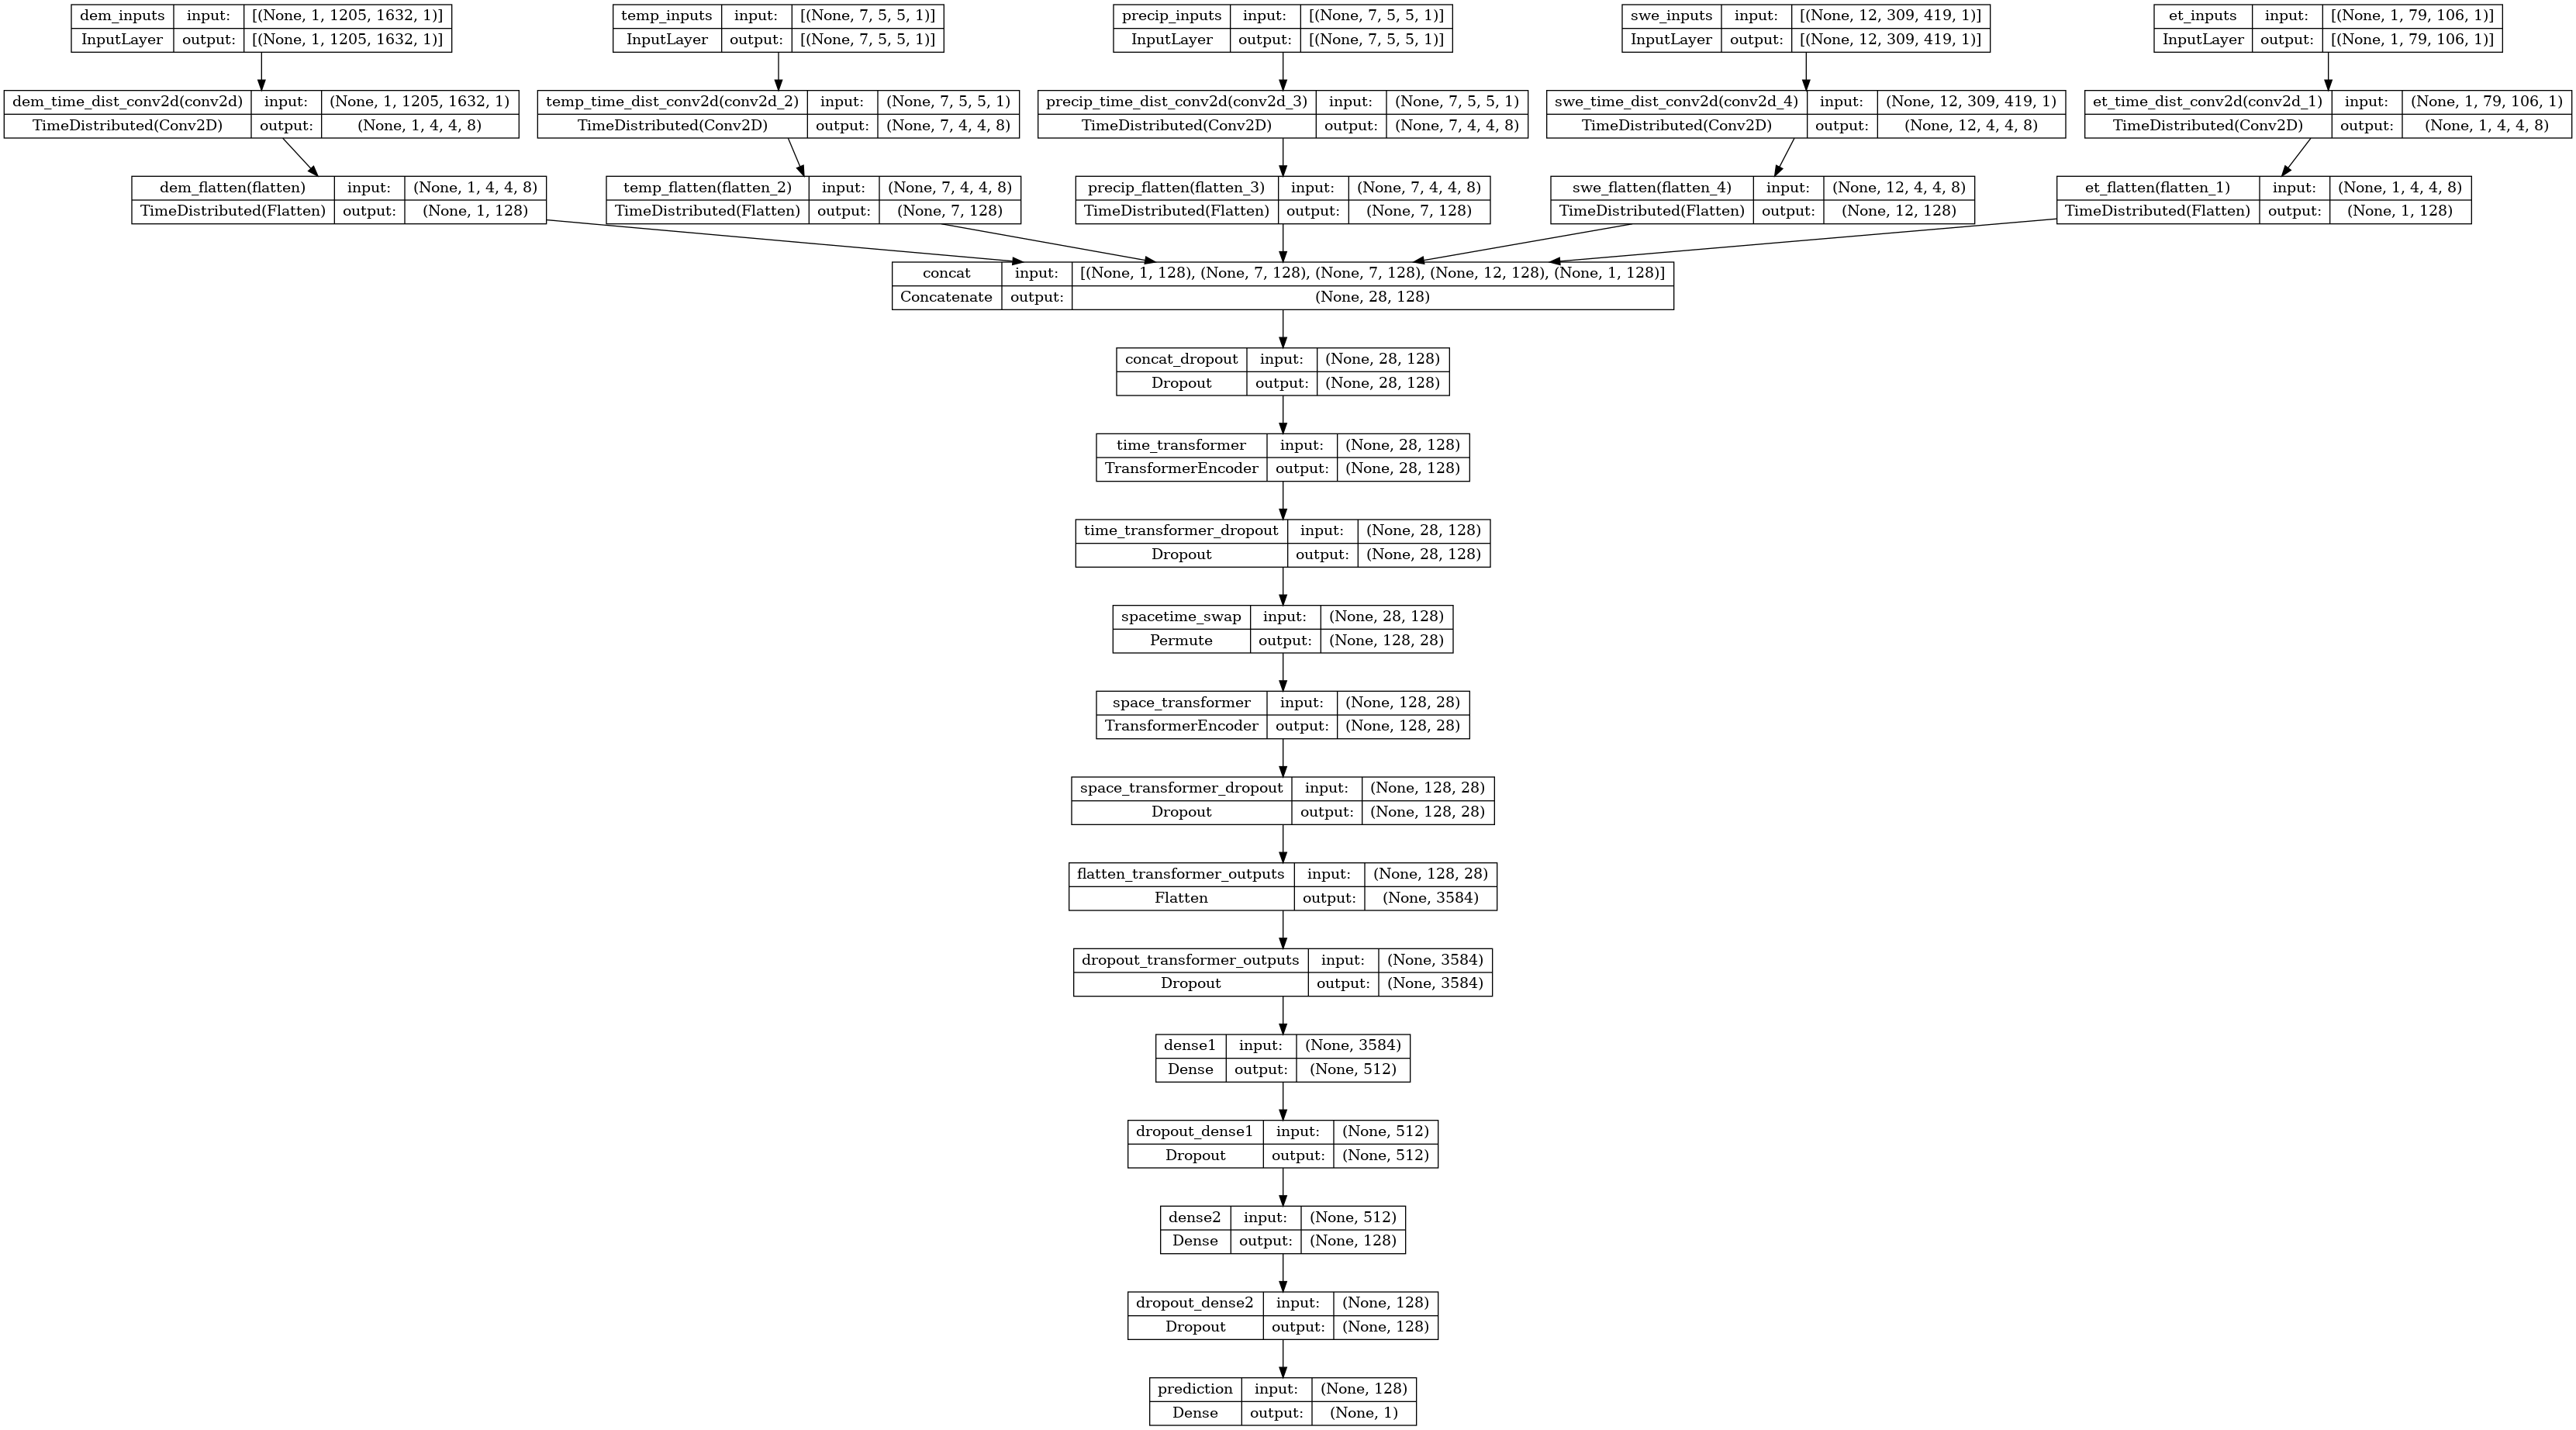

In [7]:
# Run this cell to use the SpaceTimeTransformerArchitecture:

from cnn_models import * 


experiment["architecture"] = "SpaceTimeTransformerArchitecture"


class SpaceTimeTransformerArchitecture:

    def __init__(self):
        # Get the sizes of the images for each streamgage:
        with open(os.path.join(DATA_DIR, "gage_img_sizes.yaml"), "r") as f:
            gage_sizes = yaml.safe_load(f)
        with open(os.path.join(DATA_DIR, "avg_img_sizes.yaml"), "r") as f:
            avg_sizes = yaml.safe_load(f)
        for k, v in avg_sizes.items():
            gage_sizes[k]["avg"] = v
        self.img_sizes = gage_sizes

    def get_model(self, gage: str, n_days_precip=7, n_days_temp=7, n_swe=12,
                  n_et=1, enc_dense_dim=32, enc_num_heads=2, n_y=14,
                  hidden_dim=8, dropout=0.5, pooling: str = "avg"):
        """Create a new ImgSizeCNN model architecture with the specified
        parameters."""
        input_sizes = {k: v[gage] for k, v in self.img_sizes.items()}

        kernal_stride = get_kernal_stride(input_sizes)

        # Single image CNN inputs - dem:
        dem_inputs, dem_outputs = time_dist_cnn(
            1, "dem", hidden_dim,
            kernel_size=kernal_stride["dem"]["kernal"], strides=kernal_stride["dem"]["stride"],
            pooling=pooling, w=input_sizes["dem"][0], h=input_sizes["dem"][1],
        )

        # Multiple image CNN inputs - temp / precip / swe / et:
        et_inputs, et_outputs = time_dist_cnn(
            n_et, "et", hidden_dim,
            kernel_size=kernal_stride["et"]["kernal"], strides=kernal_stride["et"]["stride"],
            pooling=pooling, w=input_sizes["et"][0], h=input_sizes["et"][1],
        )
        temp_inputs, temp_outputs = time_dist_cnn(
            n_days_temp, "temp", hidden_dim,
            kernel_size=kernal_stride["temp"]["kernal"], strides=kernal_stride["temp"]["stride"],
            pooling=pooling, w=input_sizes["temp"][0], h=input_sizes["temp"][1],
        )
        precip_inputs, precip_outputs = time_dist_cnn(
            n_days_precip, "precip", hidden_dim,
            kernel_size=kernal_stride["precip"]["kernal"], strides=kernal_stride["precip"]["stride"],
            pooling=pooling, w=input_sizes["precip"][0], h=input_sizes["precip"][1],
        )
        swe_inputs, swe_outputs = time_dist_cnn(
            n_swe, "swe", hidden_dim,
            kernel_size=kernal_stride["swe"]["kernal"], strides=kernal_stride["swe"]["stride"],
            pooling=pooling, w=input_sizes["swe"][0], h=input_sizes["swe"][1],
        )

        # Concatenate CNN outputs:
        concat = tf.keras.layers.Concatenate(axis=1, name="concat")(
            [dem_outputs, temp_outputs, precip_outputs, swe_outputs, et_outputs],
        )
        concat = layers.Dropout(dropout, name="concat_dropout")(concat)

        # Transformer encoder time dimension:
        encoder_outputs = TransformerEncoder(  # NOQA
            embed_dim=concat.shape[-1], dense_dim=enc_dense_dim, num_heads=enc_num_heads,
            name="time_transformer"
        )(concat)
        encoder_outputs = layers.Dropout(dropout, name="time_transformer_dropout")(encoder_outputs)

        # Swap the time-space axis:
        dim_swap = keras.layers.Permute((2, 1), input_shape=encoder_outputs.shape, name="spacetime_swap")(encoder_outputs)

        # Transformer encoder space dimension:
        space_encoder_outputs = TransformerEncoder(  # NOQA
            embed_dim=dim_swap.shape[-1], dense_dim=enc_dense_dim, num_heads=enc_num_heads,
            name="space_transformer"
        )(dim_swap)
        space_encoder_outputs = layers.Dropout(dropout, name="space_transformer_dropout")(space_encoder_outputs)

        flatten = layers.Flatten(name="flatten_transformer_outputs")(space_encoder_outputs)
        x = layers.Dropout(dropout, name="dropout_transformer_outputs")(flatten)

        dense1 = layers.Dense(512, activation="relu", name="dense1")(x)
        dropout_dense1 = layers.Dropout(dropout, name="dropout_dense1")(dense1)

        dense2 = layers.Dense(128, activation="relu", name="dense2")(dropout_dense1)
        dropout_dense2 = layers.Dropout(dropout, name="dropout_dense2")(dense2)

        outputs = layers.Dense(n_y, activation="linear", name="prediction")(dropout_dense2)

        transformer = keras.Model(
            [dem_inputs, temp_inputs, precip_inputs, swe_inputs, et_inputs],
            outputs
        )

        return transformer

    
def get_spacetimetransformer_model():
    # Create the model architecture:
    architecture = SpaceTimeTransformerArchitecture()
    
    model = architecture.get_model(
        PARAMETERS["gages"][0],
        n_days_precip=PARAMETERS["n_days_precip"], 
        n_days_temp=PARAMETERS["n_days_temp"],
        n_swe=PARAMETERS["n_swe"], 
        n_et=PARAMETERS["n_et"],
        enc_dense_dim=PARAMETERS["enc_dense_dim"], 
        enc_num_heads=PARAMETERS["enc_num_heads"],
        n_y=PARAMETERS["n_days_y"], 
        hidden_dim=PARAMETERS["hidden_dim"], 
        dropout=PARAMETERS["dropout"], 
        pooling=PARAMETERS["pooling"],
    )
    return model

model = get_spacetimetransformer_model()
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__spacetimetransformer_model.png")
keras.utils.plot_model(model, fp, show_shapes=True)

## Create Tensorflow datasets

In [8]:
# Run this cell as is:

def keras_train_gen(debug: bool = False):
    """Construct Keras-compatible train generator."""
    train_data_gen = cnn_data.train_data_generator()
    i = 0
    while True:

        # Generate the training sample dict, making the generator infinite:
        try:
            sample = next(train_data_gen)
        except StopIteration:
            # Reset the generator:
            train_data_gen = cnn_data.train_data_generator()
            i = 0
            sample = next(train_data_gen)

        # Print debug info:
        if debug:
            print(f"Sample {i}, {sample['debug_data']}")

        # Yield data in format required by tensorflow:
        X = [sample[ft] for ft in FEATURES]
        X = tuple([np.expand_dims(np.expand_dims(x, -1), 0) for x in X])
        yield X, np.expand_dims(sample["y"], 0)
        i += 1

def keras_val_gen(debug: bool = False):
    """Construct Keras-compatible validation generator."""
    data_gen = cnn_data.val_data_generator()
    i = 0
    while True:

        # Generate the training sample dict, making the generator infinite:
        try:
            sample = next(data_gen)
        except StopIteration:
            # Reset the generator:
            data_gen = cnn_data.val_data_generator()
            i = 0
            sample = next(data_gen)

        # Print debug info:
        if debug:
            print(f"Sample {i}, {sample['debug_data']}")

        # Yield data in format required by tensorflow:
        X = [sample[ft] for ft in FEATURES]
        X = tuple([np.expand_dims(np.expand_dims(x, -1), 0) for x in X])
        yield X, np.expand_dims(sample["y"], 0)
        i += 1

def keras_test_gen(debug: bool = False):
    """Construct Keras-compatible test generator."""
    data_gen = cnn_data.test_data_generator()
    i = 0
    while True:

        # Generate the training sample dict, making the generator infinite:
        try:
            sample = next(data_gen)
        except StopIteration:
            # Reset the generator:
            data_gen = cnn_data.test_data_generator()
            i = 0
            sample = next(data_gen)

        # Print debug info:
        if debug:
            print(f"Sample {i}, {sample['debug_data']}")

        # Yield data in format required by tensorflow:
        X = [sample[ft] for ft in FEATURES]
        X = tuple([np.expand_dims(np.expand_dims(x, -1), 0) for x in X])
        yield X, np.expand_dims(sample["y"], 0)
        i += 1

output_signature = (
    (  # X-variables:
        tf.TensorSpec(shape=(None, 1, None, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, PARAMETERS["n_days_temp"], None, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, PARAMETERS["n_days_precip"], None, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, PARAMETERS["n_swe"], None, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, PARAMETERS["n_et"], None, None, 1), dtype=tf.float32),
    ),
    # y-variable:
    tf.TensorSpec(shape=(1, PARAMETERS["n_days_y"]), dtype=tf.float32)
)
train_data = tf.data.Dataset.from_generator(keras_train_gen, output_signature=output_signature)
val_data = tf.data.Dataset.from_generator(keras_val_gen, output_signature=output_signature)
test_data = tf.data.Dataset.from_generator(keras_test_gen, output_signature=output_signature)

## Train the model

In [9]:
# Run this cell as is:

experiment["train_start_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=TF_LOG_DIR,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq=PARAMETERS["tf_board_update_freq"],
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)

ckpt_dir = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__ckpts")
if not os.path.exists(ckpt_dir):
    os.mkdir(ckpt_dir)
model_save_callback = tf.keras.callbacks.ModelCheckpoint(
    f"{ckpt_dir}/model__" + "{epoch:02d}-{val_loss:.2f}.hdf5",
    # f"{ckpt_dir}/model__" + "{epoch:02d}-NO_VAL.hdf5",
    monitor = "val_loss",
    verbose = 0,
    save_best_only = False,
    save_weights_only = False,
    mode = "auto",
    save_freq = "epoch",
    options=None,
    initial_value_threshold=None,
)


train_steps_per_epoch = len(cnn_data.train_pairs)
n_val_steps = len(cnn_data.val_pairs)
optimizer = PARAMETERS["opt"](PARAMETERS["learning_rate"])
model.compile(optimizer=optimizer, loss=PARAMETERS["loss"])
model.fit(
    train_data, epochs=PARAMETERS["epochs"], batch_size=1, 
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_data, validation_steps=n_val_steps, 
    validation_batch_size=1, validation_freq=1, 
    callbacks=[tensorboard_callback, model_save_callback]
)
experiment["train_end_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")

Epoch 1/3
1742/1742 [==============================] - 146s 82ms/step - loss: 772.3790 - val_loss: 26.7465
Epoch 2/3
1742/1742 [==============================] - 142s 82ms/step - loss: 550.9615 - val_loss: 53.3101
Epoch 3/3
1742/1742 [==============================] - 142s 81ms/step - loss: 434.0821 - val_loss: 34.5652


## Save the experiment results

In [10]:
# Use this cell to load a saved model if necessary:

# from keras.models import load_model
# from keras.utils import custom_object_scope
# from cnn_models import *

# Make sure the parameters dict matches the set up for the loaded model!
# experiment["experiment_id"] = 'f092bd20-ca80-4244-8332-5bc4875cba05'

# with custom_object_scope({
#     'TransformerEncoder': TransformerEncoder, 
#     'TransformerDecoder': TransformerDecoder
# }):
#     model = load_model(os.path.join(
#         EXPERIMENT_DIR, f"{experiment_id}__ckpts", "model__05-NO_VAL.hdf5"))

In [11]:
# Run this cell as is:

# Save the validation predictions:
experiment["val_pred_start_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
n_val_steps = len(cnn_data.val_pairs)
val_pred = model.predict(val_data, steps=n_val_steps)
columns = [f"y_day_{y+1}" for y in range(PARAMETERS["n_days_y"])]
df = pd.DataFrame(val_pred, columns=columns)
df["gage"] = [t[0] for t in cnn_data.val_pairs]
df["date"] = [t[1].to_pydatetime().date() for t in cnn_data.val_pairs]
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__val_pred.csv")
order = ["gage", "date"] + columns
df[order].to_csv(fp, encoding="utf-8", index=False)
val_pred = df[order]
experiment["val_pred_end_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")

# Save the test predictions:
experiment["test_pred_start_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
n_test_steps = len(cnn_data.test_pairs)
test_pred = model.predict(test_data, steps=n_test_steps)
columns = [f"y_day_{y+1}" for y in range(PARAMETERS["n_days_y"])]
df = pd.DataFrame(test_pred, columns=columns)
df["gage"] = [t[0] for t in cnn_data.test_pairs]
df["date"] = [t[1].to_pydatetime().date() for t in cnn_data.test_pairs]
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__test_pred.csv")
order = ["gage", "date"] + columns
df[order].to_csv(fp, encoding="utf-8", index=False)
test_pred = df[order]
experiment["test_pred_end_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")

# Save the model JSON:
model_json = model.to_json()
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__model.json")
with open(fp, "w") as f:
    json.dump(model_json, f)

# Save the full trained model:
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__trained_model")
model.save(fp)

# Save the experiment metadata:
experiment["end_time"] = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
metadata = {**PARAMETERS, **experiment}
str_metadata = {k: str(v) for k, v in metadata.items()}
fp = os.path.join(EXPERIMENT_DIR, f"{experiment_id}__metadata.yaml")
with open(fp, "w") as f:
    yaml.safe_dump(str_metadata, f)

365/365 [==============================] - 25s 69ms/step


INFO:tensorflow:Assets written to: /tf/toby/discharge-estimation/experiments/17cb69f2-488e-4e00-9ce9-ed365cef71bf__trained_model/assets


INFO:tensorflow:Assets written to: /tf/toby/discharge-estimation/experiments/17cb69f2-488e-4e00-9ce9-ed365cef71bf__trained_model/assets


In [12]:
print(f"Finished experiment id = '{experiment_id}'")

Finished experiment id = '17cb69f2-488e-4e00-9ce9-ed365cef71bf'


In [13]:
experiment["architecture"]

'SpaceTimeTransformerArchitecture'

# Calculate Average Metrics

In [12]:
%%time
ytest = []
counter = 0
for element in test_data:
    ytest.append(element[1][0].numpy())
    counter += 1
    if counter >= n_test_steps:
        break
ytest = np.array(ytest)

CPU times: user 19.3 s, sys: 9.44 s, total: 28.8 s
Wall time: 28.6 s


In [13]:
ypred = test_pred[test_pred['gage'] == '11402000'].iloc[:,2:].to_numpy()

In [14]:
def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse_list = []
mape_list = []
rrmse_list = []

for pred, truth in zip(ypred, ytest):
    rmse_list.append(np.sqrt(mean_squared_error(truth, pred)))
    mape_list.append(mean_absolute_percentage_error(truth, pred))
    rrmse_list.append(relative_root_mean_squared_error(truth, pred))
    
final_rmse = np.mean(rmse_list)
final_mape = np.mean(mape_list)
final_rrmse = np.mean(rrmse_list)

print('GAP Transformer')
print(f'RMSE = {final_rmse}')
print(f'MAPE = {final_mape}')
print(f'RRMSE = {final_rrmse}')

GAP Transformer
RMSE = nan
MAPE = nan
RRMSE = nan


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
